In [1]:
! pip show PyTDC

Name: PyTDC
Version: 0.3.8
Summary: Therapeutics Data Commons
Home-page: https://github.com/mims-harvard/TDC
Author: TDC Team
Author-email: kexinhuang@hsph.harvard.edu
License: MIT
Location: /home/nipasuma/miniconda3/envs/tdc/lib/python3.7/site-packages
Requires: fuzzywuzzy, numpy, pandas, rdkit-pypi, requests, scikit-learn, seaborn, tqdm
Required-by: 


In [2]:
RANDOM_SEED = 42

In [3]:
import pandas as pd

from tdc import utils as tdc_utils
from tdc.single_pred import Tox

from DeepPurpose import utils as dp_utils, CompoundPred

## Prepare Data

In [4]:
X, y = Tox(name = 'herg_central', label_name="hERG_inhib").get_data(format = 'DeepPurpose')

Found local copy...
Loading...
Done!


In [5]:
X, y = X[:100], y[:100]

In [6]:
pd.Series(y).value_counts()

0    95
1     5
dtype: int64

## Train

In [7]:
import io
from contextlib import redirect_stdout
from functools import lru_cache

import re

import pandas as pd
from typing import List

In [15]:
def parse_train_log(log_lines:List[str]):
    """
    Parses the log lines from `model.train` function call 
    """
    train_stats, val_stats = [], []

    for i, l in enumerate(log_lines):
        m = re.match(r"Training at Epoch (?P<epoch>\d+) iteration (?P<iter>\d+) with loss (?P<loss>\d+\.\d+). Total time 0.0 hours", l)
        if m:
            train_stats.append({"epoch": int(m.group("epoch")), "train_iter": int(m.group("iter")), "train_loss": float(m.group("loss"))})

        m = re.match(r"Validation at Epoch (?P<epoch>\d+) , AUROC: (?P<aucroc>\d+\.\d+) , AUPRC: (?P<aupr>\d+\.\d+) , F1: (?P<f1>\d+\.\d+)", l)
        if m:
            val_stats.append({"epoch": int(m.group("epoch")), "val_aucroc": float(m.group("aucroc")), "val_aupr": float(m.group("aupr")), "val_f1": float(m.group("f1"))})

        m = re.match(r"Testing AUROC: (?P<aucroc>\d+\.\d+) , AUPRC: (?P<aupr>\d+\.\d+) , F1: (?P<f1>\d+\.\d+)", l)
        if m:
            test_stats = {"test_aucroc": float(m.group("aucroc")), "test_aupr": float(m.group("aupr")), "test_f1": float(m.group("f1"))}

    train_stats_df = pd.DataFrame.from_records(train_stats)
    val_stats_df = pd.DataFrame.from_records(val_stats)

    train_val_stats_df = pd.merge(left=train_stats_df, right=val_stats_df, on="epoch", validate="1:1")

    return { "train_val": train_val_stats_df, "test": test_stats }

In [12]:
# @lru_cache() # doesn't work with Ray Tune
def prepare_data(drug_encoding):
    return dp_utils.data_process(X_drug=X, y=y, drug_encoding=drug_encoding, random_seed=RANDOM_SEED)

In [13]:
def train_fn(hparams):

    train, val, test = prepare_data(hparams["drug_encoding"])

    config = dp_utils.generate_config(
        drug_encoding=hparams["drug_encoding"], 
        train_epoch=int(hparams['train_epochs']) ,
        LR=hparams['lr'], 
        batch_size=int(hparams['batch_size']),
        mpnn_hidden_size=int(hparams['mpnn_hidden_size']),
        mpnn_depth=int(hparams['mpnn_depth'])
    )

    model = CompoundPred.model_initialize(**config)

    f = io.StringIO()
    with redirect_stdout(f):
        model.train(train, val, test)
    out = f.getvalue()
    
    results = parse_train_log(out.split("\n"))
    
    model.save_model('./tutorial_model.pt')
    results["train_val"].to_csv("train_val_stats.csv", index=False)
    return {
        **results["train_val"].to_dict(orient="records")[-1],
        **results["test"]
    }

## Tune

In [18]:
from ray import tune
from ray.tune.search.bayesopt import BayesOptSearch

from ray import air
from ray.air import session
from ray.air.callbacks.mlflow import MLflowLoggerCallback

In [19]:
search_space = {
    "drug_encoding": "MPNN",
    "lr": 0.001,
    "batch_size": 128,
    "mpnn_hidden_size": tune.uniform(8, 32),
    "mpnn_depth": 2,
    "train_epochs": 3,
}

bayesopt = BayesOptSearch(metric="train_loss", mode="min")
tuner = tune.Tuner(
    train_fn,
    tune_config=tune.TuneConfig(
        search_alg=bayesopt,
        num_samples=3
    ),
    run_config=air.RunConfig(
        name="mlflow",
        callbacks=[
            MLflowLoggerCallback(
                tracking_uri="./mlruns",
                experiment_name="test",
                save_artifact=True,
            )
        ],
    ),
    param_space=search_space,
)

analysis = tuner.fit()

2022-11-27 10:54:41,000	WARNING bayesopt_search.py:425 -- BayesOpt does not support specific sampling methods. The Uniform sampler will be dropped.


(train_fn pid=29895) Drug Property Prediction Mode...
(train_fn pid=29895) in total: 100 drugs
(train_fn pid=29895) encoding drug...
(train_fn pid=29895) unique drugs: 100
(train_fn pid=29895) Done.


Trial name,date,done,episodes_total,epoch,experiment_id,experiment_tag,hostname,iterations_since_restore,node_ip,pid,test_aucroc,test_aupr,test_f1,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,train_iter,train_loss,training_iteration,trial_id,val_aucroc,val_aupr,val_f1,warmup_time
train_fn_f3025c1c,2022-11-27_10-54-48,True,,3,8bd459adc3374f03833cc0f9611c2e2d,"1_batch_size=128,drug_encoding=MPNN,lr=0.0010,mpnn_depth=2,mpnn_hidden_size=16.9890,train_epochs=3",nipasuma-ld3.linkedin.biz,1,10.32.112.246,29895,0.745098,0.305556,0,1.91434,1.91434,1.91434,1669575288,0,,0,0.15246,1,f3025c1c,0.11111,0.11111,0,0.00574398
train_fn_f62a1ac4,2022-11-27_10-54-53,True,,3,093be4ec60d84a388c13150f5a0f6cd3,"2_batch_size=128,drug_encoding=MPNN,lr=0.0010,mpnn_depth=2,mpnn_hidden_size=30.8171,train_epochs=3",nipasuma-ld3.linkedin.biz,1,10.32.112.246,29933,0.745098,0.305556,0,1.89762,1.89762,1.89762,1669575293,0,,0,0.15246,1,f62a1ac4,0.11111,0.11111,0,0.00563979
train_fn_f948c1ba,2022-11-27_10-54-58,True,,3,cd6af8b7fd7740de95d078e6c7e77c37,"3_batch_size=128,drug_encoding=MPNN,lr=0.0010,mpnn_depth=2,mpnn_hidden_size=25.5679,train_epochs=3",nipasuma-ld3.linkedin.biz,1,10.32.112.246,30003,0.745098,0.305556,0,1.84855,1.84855,1.84855,1669575298,0,,0,0.15246,1,f948c1ba,0.11111,0.11111,0,0.00565338


(train_fn pid=29933) Drug Property Prediction Mode...
(train_fn pid=29933) in total: 100 drugs
(train_fn pid=29933) encoding drug...
(train_fn pid=29933) unique drugs: 100
(train_fn pid=29933) Done.
(train_fn pid=30003) Drug Property Prediction Mode...
(train_fn pid=30003) in total: 100 drugs
(train_fn pid=30003) encoding drug...
(train_fn pid=30003) unique drugs: 100
(train_fn pid=30003) Done.


2022-11-27 10:54:58,924	INFO tune.py:778 -- Total run time: 17.93 seconds (17.79 seconds for the tuning loop).


Explore the tuning results on mlflow dashboard as well. It can be started by running `mlflow ui --backend-store-uri examples/huggingface_examples/herg/mlruns/` in terminal. Any files saved to local disk during training can be found in the corresponding run in the `examples/huggingface_examples/herg/mlruns/` directory.

## Export to Huggingface Hub

## Appendix

{'epoch': 3,
 'train_iter': 0,
 'train_loss': 0.15246,
 'val_aucroc': 0.11111,
 'val_aupr': 0.11111,
 'val_f1': 0.0,
 'test_aucroc': 0.7450980392156863,
 'test_aupr': 0.3055555555555555,
 'test_f1': 0.0}

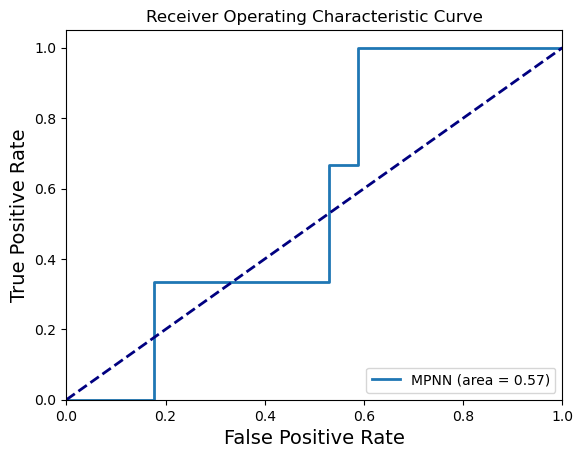

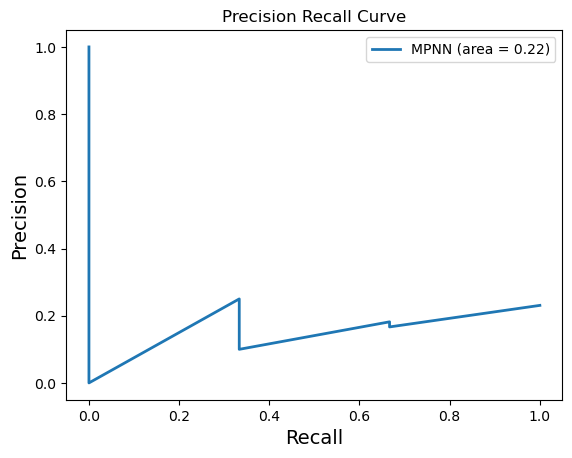

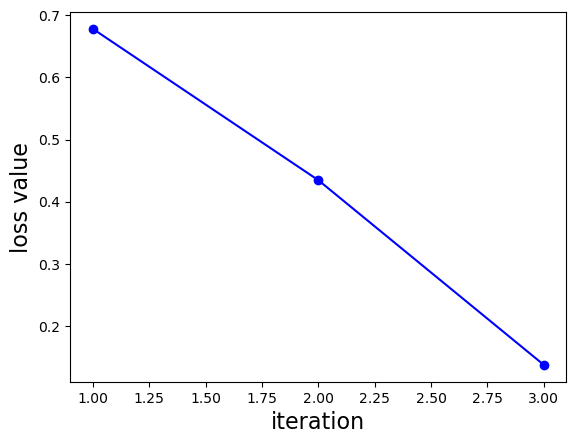

In [62]:
# train_fn({
#     "drug_encoding": "MPNN",
#     "lr": 0.001,
#     "batch_size": 128,
#     "mpnn_hidden_size": 32,
#     "mpnn_depth": 2,
#     "train_epochs": 3,
# })